# Wikiworld - Milestone P2

<div class="alert alert-block alert-info">
<b>Team:</b> flagADA22

<b>Authors:</b> Flore Barde, Manon Béchaz, Zoé Jeandupeux, Killian Rigaux
</div>

## <a id="ToC_1_WT"></a>Table of contents

1. [Data Loading and First analyses](#1.-Data-Loading-and-First-analyses)
    1. [Data Loading](#1.A-Data-Loading)
    2. [Categories of the articles](#1.B-Categories-of-the-articles)
2. [Tools](#2.Tools)
    1. [Graph Analysis and Centrality](#2.A-Graph-Analysis-and-Centrality)
        1. [Creation of the graph](#2.A.a-Creation-of-the-graph)
        2. [Centrality](#2.A.b-Centrality)
    2. [Semantic distance](#2.B-Semantic-distance)
3. [Countries](#3.-Countries)
    1. [Continents](#3.A-Continents)
    2. [What are the most important countries, according to Wikipedia's users?](#3.B-What-are-the-most-important-countries-according-to-Wikipedia's-users?)
    3. [If I say Switzerland, what do you think?](#3.C-If-I-say-Switzerland,-what-do-you-think?)
4. [People](#4.-People)
    1. [Categories of People](#4.A-Categories-of-People)
    2. [Who are the people in our dataset?](#4.B-Who-are-the-people-in-our-dataset?)
        1. [Extracting the information from the plaintext](#4.B.a-Extracting-the-information-from-the-plaintext) 
        2. [Extracting the information from the html page](#4.B.b-Extracting-the-information-from-the-html-page) 
    3. [What are the most important people according to Wikipedia's users?](#4.C-What-are-the-most-important-people-according-to-Wikipedia's-users?)
    4. [Linking people and countries](#4.D-Linking-people-and-countries)
5. [Historical events](#5.-Historical-events)
6. [Appendix](#6.-Appendix)

During this project, we are going to study the Wikispeedia data. This notebook represents a preliminary analysis of the project data. 

One first imports all necessary packages for our analysis.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from urllib.parse import unquote
import plotly.graph_objects as go
import re
from bs4 import BeautifulSoup

In [2]:
pd.options.display.max_colwidth = 200 #allows to desplay the entire strings in the dataframe

# 1. Data Loading and First analyses

## 1.A Data Loading
As a first step, we load the data from the path and graph folder: `wikispeedia_paths-and-graph`.
Amoung these data, we can find:
- `articles.tsv`: list of all the Wikipedia articles given in the Wikispeedia dataset.
- `categories.tsv`: categories to which belong a specific Wikipedia article.
- `links.tsv`: list of all the hyperlinks existing between two different Wikipedia page.
- `paths_finished.tsv`: hyperlinks path chosen by users while playing the Wikispeedia game, and were able to finish the game.
- `paths_unfinished.tsv`: hyperlinks path chosen be users while playing the Wikispeedia game, but were not able to finish the game.
- `shortest-path-distance-matrix.txt`: matrix of the smaller number of hyperlinks necessary to go from one Wikipedia article to the other.

In [3]:
# Folder
PATH_FOLDER = 'wikispeedia_paths-and-graph/'

# Defining paths
ARTICLES_DATA = PATH_FOLDER + "articles.tsv"
CATEGORIES_DATA = PATH_FOLDER + "categories.tsv"
LINKS_DATA = PATH_FOLDER + "links.tsv"
PATH_FINISHED_DATA = PATH_FOLDER + "paths_finished.tsv"
PATH_UNFINISHED_DATA = PATH_FOLDER + "paths_unfinished.tsv"
SHORTESTPATH_DATA = PATH_FOLDER + "shortest-path-distance-matrix.txt"

# Loading all data series
articles = pd.read_csv(ARTICLES_DATA, header=None, names=['article'], comment='#')
categories = pd.read_csv(CATEGORIES_DATA, sep='\t', header=None, names=['article', 'category'], comment='#')
links = pd.read_csv(LINKS_DATA, sep='\t', header=None, names=["linkSource", 'linkTarget'], comment='#')
path_finished = pd.read_csv(PATH_FINISHED_DATA, sep='\t', header=None, names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating'], comment='#')
path_unfinished = pd.read_csv(PATH_UNFINISHED_DATA, sep='\t', header=None, names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'target', 'type'], comment='#')


In [4]:
#### CODE A SUPPRIMER ?? #### TROUVER COMMENT BIEN FAIRE
shortest_path = pd.read_csv(SHORTESTPATH_DATA, sep='\t', header=None, names=['shortestPath'], comment='#')

Let's take a quick look at what the data we just loaded look like:

In [5]:
print('There are {} Wikipedia articles given in the Wikispeedia dataset.'.format(len(articles)))
articles.head(3)

There are 4604 Wikipedia articles given in the Wikispeedia dataset.


,article
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in
1,%C3%85land
2,%C3%89douard_Manet


In [6]:
categories.head(3)

,article,category
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.History.British_History.British_History_1500_and_before_including_Roman_Britain
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.People.Historical_figures
2,%C3%85land,subject.Countries


In [7]:
links.head(3)

,linkSource,linkTarget
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Bede
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Columba
2,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,D%C3%A1l_Riata


In [8]:
path_finished.head(3)

,hashedIpAddress,timestamp,durationInSec,path,rating
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific_Ocean;Atlantic_Ocean;Accra;Africa;Atlantic_slave_trade;African_slave_trade,NaN
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trade;African_slave_trade,3.0
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slavery;Africa;Atlantic_slave_trade;African_slave_trade,NaN


In [9]:
path_unfinished.head(3)

,hashedIpAddress,timestamp,durationInSec,path,target,type
0,2426091a53125110,1297054935,1804,Obi-Wan_Kenobi,Microsoft,timeout
1,26141fd878806294,1297055651,1805,Julius_Caesar,Caracas,timeout
2,2b015fb8181c48f2,1297090819,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout


As one can notice, the `path_finished` and path `path_unfinished` dataframe possess a `timestamp` column. However, the time values are in Unix Time Stamp, so not very readable. As a result, we are going to transform them in Christian time.

In [10]:
# Conversion of Unix to Christian time for the path files
path_finished['timestamp'] = pd.to_datetime(path_finished['timestamp'], unit='s', origin='unix')
path_unfinished['timestamp'] = pd.to_datetime(path_finished['timestamp'], unit='s', origin='unix')
path_finished.head(2)

,hashedIpAddress,timestamp,durationInSec,path,rating
0,6a3701d319fc3754,2011-02-15 03:26:49,166,14th_century;15th_century;16th_century;Pacific_Ocean;Atlantic_Ocean;Accra;Africa;Atlantic_slave_trade;African_slave_trade,NaN
1,3824310e536af032,2012-08-12 06:36:52,88,14th_century;Europe;Africa;Atlantic_slave_trade;African_slave_trade,3.0


## 1.B Categories of the articles

We now start by getting some insights into the categories of the Wikipedia's articles in the dataset.\
One first checks if some NaN values appear among the categories. 

In [11]:
categories.isna().sum()

article     0
category    0
dtype: int64

The previous cell shows that there is no NaN amoung the categories. Meaning that all articles present in this dataset belong to at least one category.\
As there are no NaN values to handle, we are now going to make a quick overview over the `article` dataset.

In [12]:
categories.describe()

,article,category
count,5204,5204
unique,4598,129
top,Henry_VII_of_England,subject.Countries
freq,3,229


The previous dataset description gives us some interesting insights. First of all, we can notice that there is a total of 4598 unique articles in the `categories` dataset. However, we had previously observed that there were 4604 articles in the `articles` list. This shows that some of the Wikipedia articles given in our dataset do not belong to any category.\
Moreover, one can notice that some Wikipedia articles belong to more then just one category. Indeed, the article on "Pottery" belongs to 3 different categories.\
Finally, we notice that there are 129 different categories in the dataset. And the category regrouping the highest number of articles is `subject.Countries`, with 229 articles under this category.

We are now going to group all articles by category.

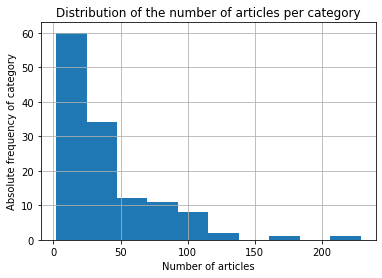

In [20]:
categories_grouped = categories.groupby(by="category")

nb_articles_per_category = categories_grouped.size()
nb_articles_per_category.hist()
plt.xlabel('Number of articles')
plt.ylabel('Absolute frequency of category')
plt.title('Distribution of the number of articles per category');

This histogram provides the distribution of articles per category. Thus, it shows the number of categories that have a certain number of articles assigned to it.\
With this representation, we can notice that most categories have less then 50 articles assigned to it. A smaller proportion of categories have between 50 and 100 articles assigned to them. Finally, the category `subject.Countries` is the only one with more then 200 articles assigned to it. 

Later in the notebook, we will interest ourselves to specific categories. Amoung them : countries, geographic regions and people.

# 2. Tools

In this part, we are going to develop the main tools that we are going to use during our analysis of the Wikispeedia dataset.

## 2.A Graph Analysis and Centrality

The finished and unfinished paths can be cast into a directed graph with Wikipedia articles as nodes and the paths connecting articles as edges. From there Graph Analysis can provide us powerful tools, for instance to explore the importance of articles, their connectivity, etc.

### 2.A.a Creation of the graph

For the sake of simplicity in this first part of the project, the idea is to focus on the graph of finished paths (at first) and then filter the paths where `<` occurs (i.e. the paths where the player had pressed the back button), but in a second step we could also decide to keep these paths but just delete the `<` as well as the previous page. We could also add later the unfinished paths to the graph.

As said before, we thus start by filtering the paths where `<` occurs.

In [6]:
def check_character(headline, character):
    '''
    This function tests if a given character is in the headline
        Inputs:
            headline: string
            character: string
        Return:
            1 if the character is in the headline
            0 otherwise
    '''
    if character in headline: 
        return 1 
    else:
         return 0

In [7]:
path_finished['back'] = path_finished['path'].apply(lambda x : check_character(x, '<'))
path_finished_filtered = path_finished[path_finished['back']==0]
path_finished_filtered.drop(columns=['back'],inplace=True)

C:\Users\manon\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


The graph is then created from a list of edges (i.e. in our case links between two articles) using the function `nx.add_edge`. 
To obtain a list of linked articles, we start by transforming the paths into a list of successive nodes (i.e. the successive articles) using the function `Convert` defined in the following cell.

In [8]:
def Convert(string):
    li = list(string.split(";"))
    return li

In [9]:
path_finished_filtered['path_list'] = path_finished_filtered['path'].apply(lambda x : Convert(x))

<ipython-input-9-3dcaea751aa0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  path_finished_filtered['path_list'] = path_finished_filtered['path'].apply(lambda x : Convert(x))


We then create a list of all edges, i.e. all pairs of articles that are connected (at least once) in the paths. We remove the duplicates; the weigths of the connections/edges (i.e. the number of times two articles are connected by Wikispeedia's players) will be taken into account later.

In [10]:
edges = []
for index, row in path_finished_filtered.iterrows(): #create the list of edges
    edges.extend(list(zip(row['path_list'][0:-2],row['path_list'][1:-1])))

edges_wo_duplicates = [] #remove duplicates
for tup in edges:
    if tup not in edges_wo_duplicates:
        edges_wo_duplicates.append(tup)


The weight is computed by counting the number of occurences of edges

In [11]:
#compute weight by counting occurences of edges in the list (before removing duplicates)
import collections
count = collections.defaultdict(int)
for elem in edges:
    count[elem] += 1

Eventually, the graph can be created by adding successively all edges and associated weights.

In [12]:
G = nx.DiGraph()
for t in edges_wo_duplicates:
    G.add_edge(t[0],t[1],weight = count[t]) #normalement on a un graphe pondéré maintenant

Another useful feature of the graph is the distance between two nodes. Here, the latter is implemented using the inverse of the weight of the corresponding edge. However, other distances could be interesting to use. In particular, one could in a second step use the semantic distance between two articles (see next section) as a distance in the graph.

In [13]:
G_distance_dict = {(e1, e2): 1 / weight for e1, e2, weight in G.edges(data='weight')}
nx.set_edge_attributes(G, G_distance_dict, 'distance')

An example of weight and distance between two articles in the graph is provided in the two following cells.

In [22]:
G.edges[('Pacific_Ocean','United_States')]['weight']

11

In [23]:
G.edges[('Pacific_Ocean','United_States')]['distance']

0.09090909090909091

### 2.A.b Centrality

Centrality is used to measure the importance (how “central” a node is in the graph) of various nodes in a graph. There exist different measures of the centrality, such as:

- **Degree Centrality** : The node with the highest degree (highest number of connections to other nodes in the network) is more important and has the higher centrality.

- **Closeness Centrality** : Here we take the average distance of a node from all the other nodes. Whichever node has a lesser average value is the node which is nearer to every node and thus it is the node with the higher centrality.

- **Betweeness Centrality** : The node that is visited most of the times while traversing the shortest paths is the one with highest centrality

- **EigenVector Centrality** : This method takes into account the neighboring nodes. A node which is connected to a node with a great importance will always get a better centrality.

The most appropriate centrality measure is our case is the **Closeness centrality**. This is the one we will use here. To account for the weight, we use the attribute `distance` defined before. We use the function `nx.closeness_centrality` to get the centrality for each article.

In [14]:
clos_centrality = nx.closeness_centrality(G, u=None, distance='distance', wf_improved=True)

In [15]:
#transform clos_centrality into a df
centralities = pd.DataFrame.from_dict(clos_centrality, orient='index',columns=['centrality'])
centralities = centralities.reset_index(level=0)
centralities = centralities.rename(columns={'index': 'article'})

In [16]:
centralities.head()

,article,centrality
0,14th_century,1.822051
1,15th_century,1.927752
2,16th_century,2.031601
3,Pacific_Ocean,2.515372
4,Atlantic_Ocean,2.538788


In view of future uses, we merge the dataframe containing the centralities with the dataframe containing the categories

In [17]:
centralities = centralities.merge(categories, on='article', how='left')
centralities.head()

,article,centrality,category
0,14th_century,1.822051,subject.History.General_history
1,15th_century,1.927752,subject.History.General_history
2,16th_century,2.031601,subject.History.General_history
3,Pacific_Ocean,2.515372,subject.Geography.General_Geography
4,Atlantic_Ocean,2.538788,subject.Geography.General_Geography


Let's eventually have a look at the most central articles in the Wikispeedia's graph: 

In [126]:
sorted_centrailities = centralities.sort_values(by=['centrality'],ascending=False)
sorted_centrailities.head()

,article,centrality,category
24,United_States,2.572896,subject.Countries
25,United_States,2.572896,subject.Geography.North_American_Geography
8,Europe,2.563019,subject.Geography.European_Geography
214,Computer,2.560876,subject.IT.Computing_hardware_and_infrastructure
192,Earth,2.560105,subject.Science.Physics.The_Planets


Note that some articles have multiple categories (such as the United States), but there is only one Wikipedia article, hence only one centrality.

In [266]:
centralities.isna().sum()

article       0
centrality    0
category      1
dtype: int64

One article has no category, we remove it from the dataframe.

In [267]:
centralities = centralities.dropna() 

In [213]:
G_nodes_centrality = dict(zip(sorted_centrailities.article, sorted_centrailities.centrality))
nx.set_node_attributes(G, G_nodes_centrality, name='centrality')

## 2.B Semantic distance

In this section, we implemented the semantic distance measure presented in the paper [*Wikispeedia: An Online Game for Inferring Semantic Distances between Concepts* by R.West, J.Pineau & D.Precup (2009)](http://infolab.stanford.edu/~west1/pubs/West-Pineau-Precup_IJCAI-09.pdf). In order to do this, we first build the Wikipedia graph `Wikigraph` with the `links` dataset.

The article names are URL-encoded. Thus, the following code allows to decode the article names, in order to get a better readability.

In [19]:
from urllib.parse import unquote

links['linkSource'] = links['linkSource'].apply(lambda x: unquote(x))
links['linkTarget'] = links['linkTarget'].apply(lambda x: unquote(x))
path_finished_unquoted=path_finished #we define a new file to still be able to use the url in the original file later
path_finished_unquoted['path'] = path_finished['path'].apply(lambda x: unquote(x))
path_finished_unquoted['path']=path_finished_unquoted['path'].apply(lambda x: Convert(x))

In [20]:
Wikigraph=nx.DiGraph()
e=zip(links['linkSource'], links['linkTarget'])
Wikigraph.add_edges_from(e)

Then, we compute the posterior click probability after seeing all the data, that is to say the probability that given the current article and the goal article, one clicks on a specific article that is linked to the current one. Specifically, it is given by:

$P^{*}(A'=a'|A=a, G=g)=\frac{N(A'=a',A=a,G=g)+\alpha}{N(A=a,G=g)+\alpha k_{a}}$

where $A, A'$ represent the current and next Wikipedia pages, $k_{a}$ is the article $a$'s out-degree and $\alpha$ is the Dirichlet parameter representing the initial confidence in the uniform prior distribution. $N(A=a,G=g)$ is a function that counts the number of paths with a goal $g$ in which the article $a$ was encountered and $N(A'=a',A=a,G=g)$ is the number of paths corresponding to the previous situation in the case where the next article is $a'$. We defined three functions to compute the posterior click probability. `count_a` returns $N(A=a,G=g)$, `count_aprime` returns $N(A'=a',A=a,G=g)$ and finally `posterior_click_probability` returns the posterior.

In [21]:
def count_a(article, goal, paths):
    '''
    This function counts the number of times an article was encountered on all paths with a specified goal
        Input: 
            article: article encountered
            goal: goal of the paths
            paths: object with all paths
        Output: 
            number of times the article was encountered summed on all paths with same given goal
        
    '''
    count=0
    for path in paths:
        if path[-1]==goal: #checks that the last element is the correct goal
            for art in path:
                if art==article and art!='<': #the comeback sign is not part of the count
                    count+=1
    return count


Note that we decide to count all the times an article could appear in the same path, because it would have a more significant value than if it just appeared once. For instance, if one went back to the same article many times, we could consider that it is because the article is relevant and thus give it more weight in the balance.

In [22]:
from itertools import cycle

In [23]:
def count_aprime(aprime, article, goal, paths):
    '''
    This function counts the number of times an article was encountered on all paths with specified previous article and goal
        Input: 
            aprime: article encountered aprime
            article: previous article
            goal: goal of the paths
            paths: object with all paths
        Output: 
            number of times the article was encountered summed on all paths with same given previous article and goal
    '''
    count=0
    if aprime=='<' or article=='<': #the comeback sign is not part of the count
        return 0

    for path in paths:
        if path[-1]==goal:
            pathcycle=cycle(path)
            next_art=next(pathcycle)
            for _ in range(len(path)-1):
                art, next_art=next_art, next(pathcycle)
                if art==article:
                    if next_art==aprime:
                            count+=1    
    return count


In [24]:
def posterior_click_probability(aprime, article, goal, paths, alpha=0.2):
    '''
    Calculates the posterior click probability to reach an article given the previous article and the goal, after seeing all the data
        Input: 
            aprime: article on which the proba is done
            article: previous article
            goal:final article 
            paths:evaluated on all those paths
            alpha:Dirichlet parameter representing initial confidence in uniform prior distribution
        Output: 
            posterior click probability for aprime, given article and goal
    '''
    
    k_a=len(list(Wikigraph.successors(article)))#number of out-degree links for article
    if count_a(article, goal, paths)!=0 and count_aprime(aprime, article, goal, paths):
        proba=(count_aprime(aprime, article, goal, paths)+alpha)/(count_a(article, goal, paths)+alpha*k_a)
    else: proba=1 #because of the log

    return proba



Next we will calculate the Google PageRank of the articles, that can be viewed as the prior probability of being on a given article.

In [25]:
GooglePageRank=nx.pagerank(Wikigraph, alpha=0.85)
print(GooglePageRank.get('United_States')) 
print(max(GooglePageRank.values())) 

0.009565545383105651
0.009565545383105651


We see that the maximum value is reached for the US, which means it will be the United States article that will be reached more times than any other articles when performing a random walk on the graph of Wikipedia (almost 1% of the time). This seems rather intuitive as it is one of the most powerful countries in the world.

Now we compute the path-specific distance $d_{path}(a_{i},g)$ from an article $a_{i}$ in the path to the goal $g$ for $i$ from 1 to $n-1$, with $n$ the length of the path. It is defined as:

$d_{path}(a_{i},g)=\frac{1}{logPageRank(g)}\sum_{j=i}^{n-1}logP^{*}(A'=a_{j+1}|A=a_{j}, G=g)$

The Google PageRank of the goal article in the denominator serves as a renormalization factor. Indeed, a concept that is hard to explain (i.e to reach on the graph) can be allowed to be linked to concepts that are further from it on the Wikipedia graph (cf. paper for more explanations). `path_distance` returns 
$d_{path}(a_{i},g)$.

In [26]:
def path_distance(a_i, goal, path):
    '''
    This function computes the distance from a given article to a goal article on one particular path
        Input: 
            a_i: given article
            g:goal
            path: specific path on which distance is computed
        Output:
            the specific distance from article to goal for the given path
    '''
    sum=0
    i=-1
    if a_i!=goal:
        for a in path:
            if a==a_i:
                i=path.index(a)
        if i==-1:
            print('Error: The article looked for is not in the path')
            return 0

        pathcycle=cycle(path[i:])
        next_a=next(pathcycle)
        for _ in range(len(path)-1):
            a_i, next_a=next_a, next(pathcycle)
            if a_i!='<':
                p=posterior_click_probability(next_a, a_i, goal, path_finished_unquoted['path'])
                sum-=np.log(p)
    
    return sum/(-np.log(GooglePageRank.get(goal)))
                
    

To get a path-independent distance from an article $a$ to the goal $g$ $d(a,g)$, we only need to average over all paths, that is to say

$d(a,g)=\frac{1}{m}\sum_{k=1}^{m}d_{path_{k}}(a,g)$

where $m$ is the number of paths going through $a$ and to $g$. This is our semantic distance and it is implemented as `semantic_distance`.

In [27]:
def semantic_distance(article, goal,paths):
    '''
    This function calculates the semantic distance between an article and a goal
        Input: 
            article, goal and all paths through which the distance is calculated
        Output:
            semantic distance for this article and goal through the given paths
    '''
    dist=0
    m=0
    pat=[]

    for path in paths:
        if path[-1]==goal:
            for a in path:
                if a==article:
                    dist+=path_distance(article, goal, path)
                    m+=1
                    pat.append(path)

    if m==0: 
        print('Error, no such path exists')
        return 0

    return dist/m 
    


To check our semantic distance, we will make a function that returns a top of the most related articles to one given goal article. As the distance is not symmetric, we decided to choose to take the article for which we want related words as the goal in our measure, for convenience and because the closest articles will be the words that are going to the goal articles, so the words one would think of when looking for the article.

In [28]:
def top_(goal, paths, n=20):
    '''
    This function computes the n closest articles to a given goal article.
        Input: 
            article: goal article
            paths: all paths on which the distance will be measured
            n: number of closest articles we want
        Output:    
            list of n closest articles to the goal or less if not enough distances have been measured with their distances to the goal
    '''
    
    top=[0 for _ in range(n)]
    dist=[]
    articles=[]
    already_calculated=False

    for i in range(len(paths)):
        if paths[i][-1]==goal:
            for article in paths[i]:
                already_calculated=False
                if article !='<' and article!=goal:
                    if len(articles)>0:
                        for art in articles:
                            if art==article:
                                already_calculated=True #to not calculate many times the same distance
                                
                    if already_calculated==False:
                        dist.append((semantic_distance(article, goal, paths),article))
                        #print('Distance between {:} and {:} has been calculated.'.format(article, goal))
                        articles.append(article)
    
    dist.sort()
    if len(dist)>=n:
        top=dist[:n]
    else:
        for j in range(len(dist)):
            top[j]=dist[j]

    return top

In [29]:
top=top_('Noam_Chomsky', path_finished_unquoted['path'])
top

[(0.10443895274732024, 'Scheme_programming_language'),
 (0.16730024036998317, 'Psychology'),
 (0.2367916565801112, 'Linguistics'),
 (0.30504371738085306, 'Communication'),
 (0.31027981651003655, 'Tourette_syndrome'),
 (0.36232543086334995, 'Stephen_Jay_Gould'),
 (0.392790541298524, 'La_Paz'),
 (0.4370001363732602, 'Language'),
 (0.526264526967477, 'Arab-Israeli_conflict'),
 (0.526264526967477, 'The_Holocaust'),
 (0.6607988370652125, 'Alternating_current'),
 (0.6607988370652125, 'Radio_frequency'),
 (0.7256788032770468, 'Socialism'),
 (0.770277274205617, 'Sound'),
 (0.8757147883850194, 'Alphabet'),
 (0.9047884224331657, 'Philosophy'),
 (0.9127820967019243, 'Music'),
 (0.9467907452366382, 'Jew'),
 (0.9835366208061289, 'World_War_II'),
 (1.0460084203966824, 'Communism')]

We see that the first concepts (and even some after) are related to Noam Chomsky. However, some other articles, such as La Paz, have nothing to do with Chomsky. Note that La Paz is also present when calculating the closest words in the paper. This is because we have not filtered the paths yet. Indeed, when a player looks for a goal article, it first goes to a hub to redirect themselves and only then narrows down again to concepts related to the goal article. Some articles thus should not be taken into account, and the filtering is to be continued in the next milestone!

# 3. Countries

With the tools ready, we start by investigating the subset of the dataset related to countries. The goal is to answer the following research questions: 
- Which countries seem to have the most influence according to Wikipedia users? Is this representative of the real political influence of these countries?
- To which continent do these most famous countries belong to? Do some continents disappear from this representation?

We first start by extracting the articles belonging to the `subject.Countries` category.

In [21]:
countries = categories_grouped.get_group('subject.Countries')
print("There are {} countries in the dataset.".format(len(countries)))

countries

There are 229 countries in the dataset.


,article,category
2,%C3%85land,subject.Countries
5,%C3%89ire,subject.Countries
102,Abkhazia,subject.Countries
109,Abu_Dhabi,subject.Countries
141,Afghanistan,subject.Countries
...,...,...
5022,West_Bank,subject.Countries
5031,Western_Sahara,subject.Countries
5159,Yemen,subject.Countries
5182,Zambia,subject.Countries


## 3.A Continents

We now have the list of all countries but it does not give us much information about the continent to which they belong, and therefore their location in the world. As a result, we are now going to add the continent information for each country.\
In order to do so, we are going to use the fact that each country article actually belongs to two different category. The first one is `subject.Countries` as shown before and the second one is more specific to the continent or region to which belongs the country. For example, a country in Europe belongs to the category `subject.Geography.European_Geography.European_Countries` and the US belong to the category `subject.Geography.North_American_Geography`.

Grouping the countries belonging to the continents Europe, Asia, Africa, South America and Middle East is straighforward, as there exists a specific category for each. 


In [51]:
#Regroup European countries
European_countries= categories_grouped.get_group('subject.Geography.European_Geography.European_Countries')
European_countries.insert(1, 'Continent', 'European')
print('There are {} European countries.'.format(len(European_countries)))

#Regroup Asian countries
Asian_countries= categories_grouped.get_group('subject.Geography.Geography_of_Asia.Asian_Countries')
Asian_countries.insert(1, 'Continent', 'Asian')
print('There are {} Asian countries.'.format(len(Asian_countries)))

#Regroup African countries
African_countries= categories_grouped.get_group('subject.Geography.African_Geography.African_Countries')
African_countries.insert(1, 'Continent', 'African')
print('There are {} African countries.'.format(len(African_countries)))

#Regroup South American countries 
SC_American_countries= categories_grouped.get_group('subject.Geography.Central_and_South_American_Geography.Central_and_South_American_Countries')
SC_American_countries.insert(1, 'Continent', 'SC American')
print('There are {} Central/South American countries.'.format(len(SC_American_countries)))

#Regroup Middle East countries
Mid_Eastern_countries= categories_grouped.get_group('subject.Geography.Geography_of_the_Middle_East.Middle_Eastern_Countries')
Mid_Eastern_countries.insert(1, 'Continent', 'Middle Eastern')
print('There are {} Middle Eastern countries.'.format(len(Mid_Eastern_countries)))


There are 56 European countries.
There are 37 Asian countries.
There are 57 African countries.
There are 48 Central/South American countries.
There are 18 Middle Eastern countries.


However, for North American and Oceania/Australasia countries, one needs to do things a little bit differently. Indeed, there is no specific category for the North American (Oceania/Australasia) countries, and they are mixed up with regions, states, etc. in a bigger category `subject.Geography.North_American_Geography` (`subject.Geography.Geography_of_Oceania_Australasia`).\
Thus, in order to extract the countries from the other geographical regions, we first group together the North American (Oceania/Australasia) regions. Then, for each region, we check if this region is present in the `countries` dataframe. If it is present, this means that the region is a country, and therefore we can add it to a `North_American_countries` (`Oceania_Australasia_countries`) dataframe. 


In [23]:
#Need to do it differently for North American countries, because there is no .North_American_Countries category
North_American_geography= categories_grouped.get_group('subject.Geography.North_American_Geography') #Group together the North American regions
North_American_countries = pd.DataFrame(columns = ['article','category']) #Create a North Amercian countries dataframe that is going to fill
for idx, NA_geo in enumerate(North_American_geography['article']): #Check for all North American regions
    if (NA_geo in countries['article'].unique()): #Check if the region is a country
        North_American_countries= pd.concat([North_American_countries, North_American_geography[North_American_geography.article==NA_geo]] ,join='outer') #Add the country to the dataframe

North_American_countries.insert(1, 'Continent', 'North American')

print('There are {} North American countries.'.format(len(North_American_countries)))

There are 4 North American countries.


In [24]:
#Same for Oceania/Australasia continent
Geography_of_Oceania_Australasia = categories_grouped.get_group('subject.Geography.Geography_of_Oceania_Australasia') #Group together the Oceania/Australasia 
Oceania_Australasia_countries = pd.DataFrame(columns = ['article','category']) #Group together the Oceania Australasia regions
for idx, Oce_geo in enumerate(Geography_of_Oceania_Australasia['article']): #Check for all Oceania Australasia regions
    if (Oce_geo in countries['article'].unique()): #Check if the region is a country
        Oceania_Australasia_countries= pd.concat([Oceania_Australasia_countries, Geography_of_Oceania_Australasia[Geography_of_Oceania_Australasia.article==Oce_geo]] ,join='outer') #add the country to the dataframe

Oceania_Australasia_countries.insert(1, 'Continent', 'Oceania Australasia')

print('There are {} Oceania/Australasia countries.'.format(len(Oceania_Australasia_countries)))

There are 15 Oceania/Australasia countries.


Now that we have the dataframes with the countries of each continent, we are going to add this information to the `countries` dataframe.\
In order to do so, we first concatenate the continents dataframes, and then merge this dataframe with the `countries` dataframe, on the `article` name column. The resulting dataframe `all_countries` countains the countries name (article name), their two type of catergory, as well as the name of the continent to which they belong.

In [25]:
all_continents = pd.concat([European_countries, Asian_countries, African_countries, SC_American_countries, Mid_Eastern_countries, North_American_countries, Oceania_Australasia_countries])
all_countries = countries.merge(all_continents, how='outer', on = ['article'])
all_countries.sample(10)

,article,category_x,Continent,category_y
82,Germany,subject.Countries,European,subject.Geography.European_Geography.European_Countries
58,Djibouti,subject.Countries,African,subject.Geography.African_Geography.African_Countries
27,Bolivia,subject.Countries,SC American,subject.Geography.Central_and_South_American_Geography.Central_and_South_American_Countries
75,France,subject.Countries,European,subject.Geography.European_Geography.European_Countries
150,Oman,subject.Countries,Middle Eastern,subject.Geography.Geography_of_the_Middle_East.Middle_Eastern_Countries
195,Sweden,subject.Countries,European,subject.Geography.European_Geography.European_Countries
148,North_Korea,subject.Countries,Asian,subject.Geography.Geography_of_Asia.Asian_Countries
225,West_Bank,subject.Countries,Middle Eastern,subject.Geography.Geography_of_the_Middle_East.Middle_Eastern_Countries
45,Chile,subject.Countries,SC American,subject.Geography.Central_and_South_American_Geography.Central_and_South_American_Countries
26,Bhutan,subject.Countries,Asian,subject.Geography.Geography_of_Asia.Asian_Countries


In [26]:
all_countries.isna().sum()

article       0
category_x    5
Continent     0
category_y    0
dtype: int64

With the cell above, we notice that 5 countries have a NaN value in their `category_x` column. This means that these countries did not belong to the category `subject.Countries`, but still belonged to the country category of a continent.\
An example of country in this situation is Mayotte. Mayotte is an island located between Madagascar and Northeastern Mozambique. So it is located in the African continent. However, Mayotte is not a country in itself but is actually an overseas department and region of France. Thus, it is not a country in itself but is still categorized as an African country.\
For our analysis, we decided to keep these regions, and to consider them as independent countries. Indeed, maybe France will be seen as one of the most influential countries, but the small island of Mayotte doesn't really play a role in this influence, as it is in a completelly different geographical region. 

With the dataframe containing all the countries and the continent to which they belong, we can now look at their repartition. The following histogram gives the repartition of the number of countries per continent.

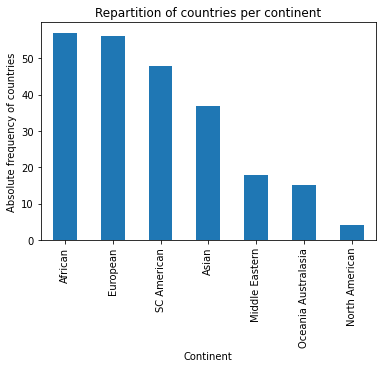

In [27]:
all_countries['Continent'].value_counts().plot(kind="bar")
plt.xlabel('Continent')
plt.ylabel('Absolute frequency of countries')
plt.title('Repartition of countries per continent');


The histogram above shows that Africa and Europe both possess the highest number of countries, with more then 50 countries each. On the other hand, North America has the smallest number of countries, with only 4 countries.\
However, does the number of countries in the continent really has an importance, when looking at the influence of a certain continent ? Africa has the highest number of countries, but are these countries influencial ? It is what we are going to see in the next section. 

## 3.B What are the most important countries according to Wikipedia's users?

Using the centrality computed before, one could determine what countries are the most central in the graph created from the paths. This can provide us with interesting information on the importance of different countries for Wikipedia's users. Are some countries more important than others?

To this end, we filter the dataframe with the centralities obtained before to keep only the countries.

In [127]:
centralities_grouped = sorted_centrailities.groupby(by="category")
countries_centralities = centralities_grouped.get_group('subject.Countries')
countries_centralities = countries_centralities.rename(columns={'article': 'country'})
print("There are {} countries in the dataset.".format(countries_centralities.shape[0]))
countries_centralities.head(10)

There are 228 countries in the dataset.


,country,centrality,category
24,United_States,2.572896,subject.Countries
245,United_Kingdom,2.558441,subject.Countries
793,Norway,2.530908,subject.Countries
190,Germany,2.529179,subject.Countries
678,Mexico,2.501755,subject.Countries
758,Canada,2.498474,subject.Countries
416,Russia,2.495679,subject.Countries
17,Italy,2.485946,subject.Countries
60,France,2.480527,subject.Countries
482,South_Africa,2.473290,subject.Countries


The idea is then to create a map to visualize the centrality/importance of the countries. The most impactful visualization for such data is probably a cartogram, the latter is however not easily implemented. Thus, as a first step, we will use a choropleth map. Latter in this project, a cartogram could be created.

To create the map, we will use `plotly.graph_objects`. However, to plot the countries we need their alpha-3 (iso-3) code. The latter can be found in many datasets, we used the following one :

In [128]:
iso = pd.read_csv('https://github.com/Dinuks/country-nationality-list/raw/master/countries.csv')
iso = iso[["alpha_3_code", "en_short_name"]]
iso.columns = ["iso3", "country"]

By comparing the Country names in our dataset and in this one, we observe that some countries have different designations.

To solve this issue, we first replace the underscores in the names of the countries and then manually determine the countries with different names in the two datasets. We change the names in the second dataframe to match with the first one. 


In [129]:
# Remove the underscore in the names of the countries
countries_centralities['country'] = countries_centralities['country'].apply(lambda x : x.replace('_', ' '))

In [130]:
iso['country'] = iso['country'].replace(['United States of America'], 'United States')
iso['country'] = iso['country'].replace(['United Kingdom of Great Britain and Northern Ireland'], 'United Kingdom')
iso['country'] = iso['country'].replace(['Russian Federation'], 'Russia')
#iso['country'] = iso['country'].replace(['Ireland'], 'Republic of Ireland')
iso['country'] = iso['country'].replace(['China'], 'Republic of China')
iso['country'] = iso['country'].replace(['Bolivia (Plurinational State of)'], 'Bolivia')
iso['country'] = iso['country'].replace(['Vatican City State'], 'Vatican City')
iso['country'] = iso['country'].replace(["Korea (Democratic People's Republic of)"], 'North Korea')
iso['country'] = iso['country'].replace(["Korea (Republic of)"], 'South Korea')
iso['country'] = iso['country'].replace(["Tanzania, United Republic of"], 'Tanzania')
iso['country'] = iso['country'].replace(["Macedonia (the former Yugoslav Republic of)"], 'Republic of Macedonia')
iso['country'] = iso['country'].replace(["Georgia"], 'Georgia %28country%29')
iso['country'] = iso['country'].replace(["Taiwan, Province of China"], 'Taiwan')
iso['country'] = iso['country'].replace(["Côte d'Ivoire"], 'C%C3%B4te d%27Ivoire')
iso['country'] = iso['country'].replace(["Gambia"], 'The Gambia')
iso['country'] = iso['country'].replace(["Venezuela (Bolivarian Republic of)"], 'Venezuela')
iso['country'] = iso['country'].replace(["Bahamas"], 'The Bahamas')
iso['country'] = iso['country'].replace(["Moldova (Republic of)"], 'Moldova')
iso['country'] = iso['country'].replace(["Falkland Islands (Malvinas)"], 'Falkland Islands')
iso['country'] = iso['country'].replace(["Lao People's Democratic Republic"], 'Laos')
iso['country'] = iso['country'].replace(["Syrian Arab Republic"], 'Syria')
iso['country'] = iso['country'].replace(["Micronesia (Federated States of)"], 'Federated States of Micronesia')
iso['country'] = iso['country'].replace(["Palestine, State of"], 'Palestinian territories')
iso['country'] = iso['country'].replace(["Saint Helena, Ascension and Tristan da Cunha"], 'Saint Helena')
iso['country'] = iso['country'].replace(["Sao Tome and Principe"], 'S%C3%A3o Tom%C3%A9 and Pr%C3%ADncipe')
iso['country'] = iso['country'].replace(["Timor-Leste"], 'East Timor')
iso['country'] = iso['country'].replace(["Cocos (Keeling) Islands"], 'Cocos %28Keeling%29 Islands')
iso['country'] = iso['country'].replace(["United Arab Emirates"], 'Dubai')
iso['country'] = iso['country'].replace(["Cabo Verde"], 'Cape Verde')
iso['country'] = iso['country'].replace(["Åland Islands"], '%C3%85land')
iso['country'] = iso['country'].replace(["Brunei Darussalam"], 'Brunei')
iso['country'] = iso['country'].replace(["Réunion"], 'R%C3%A9union')
iso['country'] = iso['country'].replace(["Serbia"], 'Serbia and Montenegro')
#iso['country'] = iso['country'].replace(["Cyprus"], 'Turkish Republic of Northern Cyprus'

Now we can merge the two dataframes to obtain, for each country, their alpha-3 code. Note that some country appear only in one of the two datasets, leading to Nan values in the resulting dataframe. We simply remove these countries.

In [131]:
countries = countries_centralities.merge(iso, on='country', how='left')
countries = countries.dropna() 
countries.head()

,country,centrality,category,iso3
0,United States,2.572896,subject.Countries,USA
1,United Kingdom,2.558441,subject.Countries,GBR
2,Norway,2.530908,subject.Countries,NOR
3,Germany,2.529179,subject.Countries,DEU
4,Mexico,2.501755,subject.Countries,MEX


Eventually, we can plot the map:

In [132]:
fig = go.Figure(data=go.Choropleth(
    locations = countries['iso3'],
    z = countries['centrality'],
    text = countries['country'],
    colorscale = 'turbo',
    autocolorscale=False,
    reversescale=False,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_tickprefix = '',
    colorbar_title = 'centrality',
))

fig.update_layout(
    title_text='Countries centrality',
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    )
)

fig.show()

To increase the readability and understanding, we could transform the centrality into a score ranging from 1 to 10. However, it is interesting to check if the distribution fo the centralities is heavy tailed or follows a known distribution, in order to adapt the normalization and the scaling. To this end, we start by visualizing the distribution of the centralities via a histogram and a box-plot.

Text(0.5, 1.0, 'Distribution of centralities')

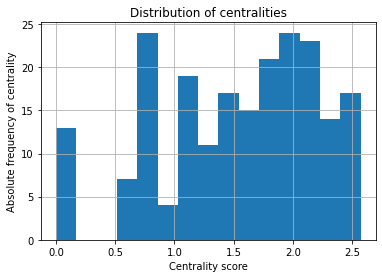

In [133]:
countries['centrality'].hist(bins = 15)
plt.xlabel('Centrality score')
plt.ylabel('Absolute frequency of centrality')
plt.title('Distribution of centralities')

In [134]:
countries['centrality'].describe()

count    209.000000
mean       1.526399
std        0.678176
min        0.000000
25%        1.100468
50%        1.686658
75%        2.067456
max        2.572896
Name: centrality, dtype: float64

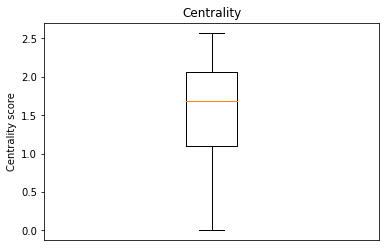

In [36]:
plt.boxplot(countries['centrality'])
plt.xticks([])
plt.ylabel('Centrality score')
plt.title('Centrality');

We do not recognize a typical underlying distribution. Therefore, in order to contruct a score ranging from 0 to 10 we simply scale the centralities using a min-max scale.

In [37]:
countries['score'] = 10*(countries['centrality']-countries['centrality'].min())/(countries['centrality'].max()-countries['centrality'].min())

Here is the final map obtained:

In [38]:
fig = go.Figure(data=go.Choropleth(
    locations = countries['iso3'],
    z = countries['score'],
    text = countries['country'],
    colorscale = 'turbo',
    autocolorscale=False,
    reversescale=False,
    marker_line_color='grey',
    marker_line_width=0.5,
    colorbar_tickprefix = '',
    colorbar_title = 'Score',
))

fig.update_layout(
    title_text='Countries score',
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    )
)

fig.show()

## Importance of the continents

In [61]:
all_countries = pd.DataFrame(all_countries)
all_countries.head()

,article,category_x,Continent,category_y
0,%C3%85land,subject.Countries,European,subject.Geography.European_Geography.European_Countries
1,%C3%89ire,subject.Countries,European,subject.Geography.European_Geography.European_Countries
2,Abkhazia,subject.Countries,Asian,subject.Geography.Geography_of_Asia.Asian_Countries
3,Abu_Dhabi,subject.Countries,Middle Eastern,subject.Geography.Geography_of_the_Middle_East.Middle_Eastern_Countries
4,Afghanistan,subject.Countries,Asian,subject.Geography.Geography_of_Asia.Asian_Countries


In [64]:
centralities_row = centralities.drop(['category'], axis=1)
all_countries_row = all_countries.drop(['category_x','category_y'],axis=1)

In [66]:
countries_centralities_continent = all_countries_row.merge(centralities_row,on='article', how='left')

,article,Continent,centrality
0,%C3%85land,European,0.678558
1,%C3%85land,European,0.678558
2,%C3%89ire,European,0.705472
3,%C3%89ire,European,0.705472
4,Abkhazia,Asian,0.000000


In [67]:
countries_centralities_continent_grouped = countries_centralities_continent.groupby('Continent')

In [73]:
mean_centrality_continent = pd.DataFrame(countries_centralities_continent_grouped.agg('mean'))
std_centrality_continent = pd.DataFrame(countries_centralities_continent_grouped.agg('std'))
mean_centrality_continent.head(10)

,centrality
Continent,
African,1.528142
Asian,1.541756
European,1.720344
Middle Eastern,1.332062
North American,2.438162
Oceania Australasia,0.917468
SC American,1.303719


Text(0, 0.5, 'Mean centrality')

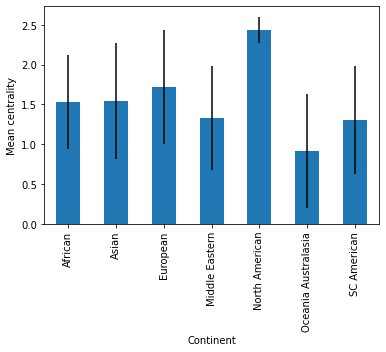

In [77]:
mean_centrality_continent['centrality'].plot(kind="bar",yerr = std_centrality_continent)
plt.xlabel('Continent')
plt.ylabel('Mean centrality')
#plt.title('Repartition of countries per continent');

## Subgraph with only the countries

In [245]:
countries_centralities = countries_centralities.sort_values(by=['centrality'],ascending=False)
countries_list = countries_centralities['article'] #.loc[idxs]
countries_list = countries_list.to_numpy()
countries_list = countries_list[0:14]
countries_list

array(['United_States', 'United_Kingdom', 'Norway', 'Germany', 'Mexico',
       'Canada', 'Russia', 'Italy', 'France', 'South_Africa', 'Japan',
       'China', 'India', 'Netherlands'], dtype=object)

In [246]:
countries_centralities = pd.DataFrame(countries_centralities)
countries_centr_list = countries_centralities['centrality'].to_numpy() #.loc[idxs]
countries_centr_list = countries_centr_list[0:14]
countries_centr_list

array([2.57289561, 2.55844088, 2.53090775, 2.52917864, 2.50175505,
       2.49847417, 2.49567905, 2.48594634, 2.4805265 , 2.47329018,
       2.45253258, 2.45064844, 2.44658836, 2.44575076])

In [247]:
subgraph_countries = G.subgraph(countries_list)
edges = subgraph_countries.edges()
weights = [subgraph_countries[u][v]['weight'] for u,v in edges]
centrality_nodes = list(nx.get_node_attributes(subgraph_countries,'centrality').values())

[   65.87735343  4146.72021944  3161.40048866  2735.12770995
  8863.12935716   385.20455137  6697.63571095  6561.64051458
 10000.          4404.76232887     0.          3926.88251234
  2165.98763261   533.39322308]


{'India': Text(0.9999999914850508, 1.901690784043941e-08, 'India'),
 'Canada': Text(0.9009688415656395, 0.43388377356881347, 'Canada'),
 'Italy': Text(0.6234897902033594, 0.7818315186027088, 'Italy'),
 'France': Text(0.22252097205383023, 0.9749279170878568, 'France'),
 'United_Kingdom': Text(-0.2225209507664572, 0.9749279170878568, 'United_Kingdom'),
 'China': Text(-0.6234897987183086, 0.7818315186027088, 'China'),
 'Norway': Text(-0.9009688500805887, 0.43388383317345797, 'Norway'),
 'Germany': Text(-1.0, -6.840586836083619e-08, 'Germany'),
 'United_States': Text(-0.9009688500805887, -0.43388373553499776, 'United_States'),
 'Mexico': Text(-0.623489619904375, -0.7818315997781822, 'Mexico'),
 'Netherlands': Text(-0.2225210103711017, -0.9749278790540411, 'Netherlands'),
 'Russia': Text(0.22252103165847475, -0.9749278790540411, 'Russia'),
 'South_Africa': Text(0.6234896113894258, -0.7818315997781822, 'South_Africa'),
 'Japan': Text(0.9009688415656395, -0.43388373553499776, 'Japan')}

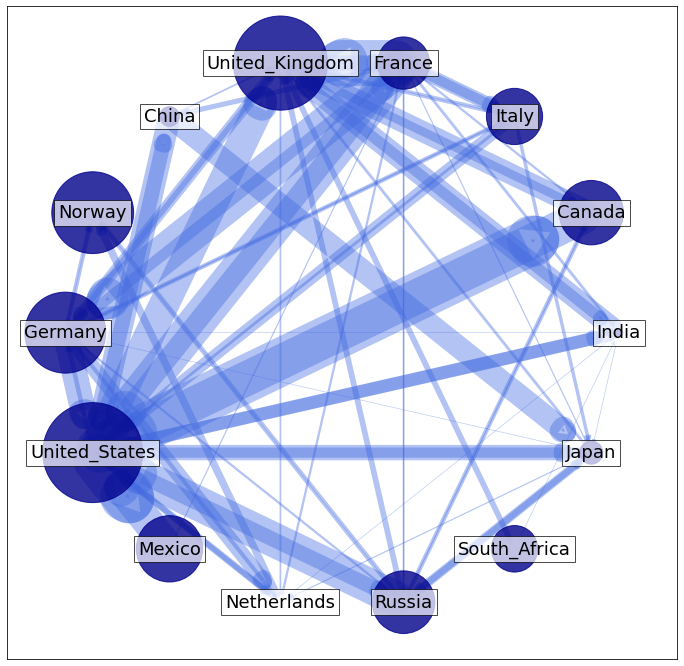

In [255]:
#graph esthetic parameters
max_node_size = 10000
max_edge_width = 50

#extract edges weigths, normalize them and define their width in the graph
weights = np.array([subgraph_countries[u][v]['weight'] for u,v in subgraph_countries.edges()])
weights = (weights - np.min(weights)) / (np.max(weights)-np.min(weights))
weights *= max_edge_width

#extract lexical fields total scores over the whole corpus, normalize them and define their width in the graph
nodes_size = list(nx.get_node_attributes(subgraph_countries,'centrality').values())
nodes_size = (nodes_size - np.min(nodes_size)) / (np.max(nodes_size) - np.min(nodes_size))
nodes_size *= max_node_size
print(nodes_size)
# Generate layout for visualization
pos = nx.circular_layout(subgraph_countries)

fig, ax = plt.subplots(figsize=(12, 12))
#nx.draw_circular(subgraph_countries, width = weights, with_labels=True, node_size=nodes_size, node_color="#210070",edge_color="m",alpha=0.7)
# Visualize graph components
nx.draw_networkx_edges(subgraph_countries, pos, alpha=0.4, width = weights, edge_color="royalblue")
nx.draw_networkx_nodes(subgraph_countries, pos, node_size=nodes_size, node_color="darkblue", alpha=0.8)
label_options = {"ec": "k", "fc": "white", "alpha": 0.7}
nx.draw_networkx_labels(subgraph_countries, pos, font_size=18, bbox=label_options)

## 3.C If I say Switzerland, what do you think?

Using the semantic distance, one could investigate what concepts/articles are the closest (in terms of semantic distance) to countries, and thus investigate what image of the countries is given by their semantically-close concepts, i.e. see what people link the countries to (e.g. Switzerland -> Chocolate? UK -> Fish&Chips? Italy -> Pizza?) 

To sum up, how can we describe the countries in our Wikiworld?

In [ ]:
top_us=top_('United_States', path_finished_unquoted['path'], 10)
top_us

[(0.18223075302814007, 'Baker_Island'),
 (0.28900084162789624, 'American_Samoa'),
 (0.3153692706331039, 'Advertising'),
 (0.33885507194956943, 'Domesticated_turkey'),
 (0.39698717947338574, 'Igor_Stravinsky'),
 (0.402573800977865, 'Whale'),
 (0.4128522745416157, 'Soviet_Union'),
 (0.44270337143890126, 'United_States_dollar'),
 (0.4516660364010413, 'Hubble_Space_Telescope'),
 (0.4765097205277174, 'History_of_Arizona')]

In [ ]:
top_is=top_('Iceland', path_finished_unquoted['path'], 10)
top_is

[(0.30358370172055105, 'Glacier'),
 (0.4421037982901516, 'Greenland'),
 (0.6049247648676985, 'Cuba'),
 (0.6190868461950098, 'Switzerland'),
 (0.6857180122008376, 'Viking'),
 (0.7045422177523002, 'Norway'),
 (0.7503823733953766, 'French_Polynesia'),
 (0.7759682370468759, 'James_Joyce'),
 (0.7892776227235532, 'WorkChoices'),
 (0.8028132160106688, 'Time_zone')]

As before when testing the semantic distance, we observe that the first associated words/concepts make sense, while some others are much more surprising. As said before, some improvement need to be made on the semantic distance, that will probably change a bit the results. However, these first tests confirm that such a distance can indeed be interesting to use to characterize the countries.

More in the next Milestone!

# 4. People

We now investigate the subset of the dataset related to peoples. The goal is to answer the following questions:
- Who are the most famous persons?
- To which domain to they belong? What is their gender? Are they dead or alive?

## 4.A Categories of People

There are many articles about people in the given dataset. Thus, it is interesting to first understand how the people are categorized.\
We first determine how many classes of articles about people there are. In order to do so, we filter all the categories which possess the word 'People' in the name of their category.

In [257]:
#Group all the articles about people together.
people = categories_grouped.filter(lambda x: 'People' in str(x['category'])) 
people_grouped = people.groupby(by="category")
print("There are {0} people in the dataset, that are divided in {1} different classes.".format(people.nunique()[0],people.nunique()[1]))


There are 698 people in the dataset, that are divided in 21 different classes.


Let's have a look at the `people` dataframe created:

In [258]:
people.head(3)

,article,category
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.People.Historical_figures
4,%C3%89douard_Manet,subject.People.Artists
8,%C3%93engus_I_of_the_Picts,subject.People.Historical_figures


In [259]:
people.describe()

,article,category
count,711,711
unique,698,21
top,Ulysses_S._Grant,subject.People.Historical_figures
freq,2,108


In [260]:
people.category[people.article=='Leonardo_da_Vinci']

2764                    subject.People.Artists
2765    subject.People.Engineers_and_inventors
Name: category, dtype: object

There are 698 people in the dataset, that are divided in 21 different classes. Some people appear in different categories, but not more then two different. For example, Leonardo da Vinci, which was active as a painter, draughtsman, engineer, scientist, theorist, sculptor, and architect, is classified into the categories `subject.People.Artists` and `subject.People.Engineers_and_inventors` of Wikipedia.

Let's now have an overview of the 21 categories to which the peoples' articles belong.

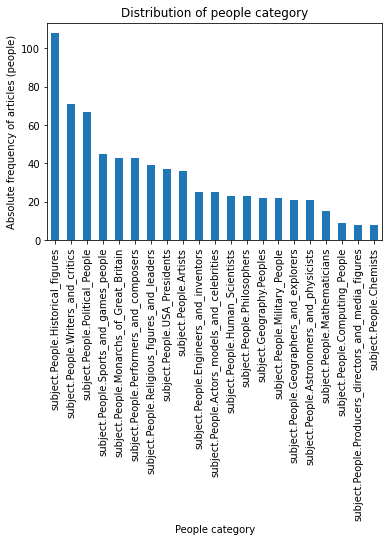

In [261]:
people['category'].value_counts().plot(kind="bar")
plt.xlabel('People category')
plt.ylabel('Absolute frequency of articles (people)')
plt.title('Distribution of people category');

With the previous histogram, one can see that the category `subject.People.Historical_figures` countains the highest number of people, with more then 100 articles. The categories `subject.People.Writers_and_critics` and `subject.People.Political_People` are also very much represented with more then 60 articles each. 

As there are a lot of different categories for classifying peolples' articles, we might decide later on to regroup some of these categories together. Indeed, `..._Astronomers_and_physicists`, `..._Chemists`, `..._Mathematicians` and `..._Human_Scientists` could all be regrouped into the same category, as they all are researchers in fundamental sciences.

We can also extract articles about people belonging to a specific category. For example, below we create a new dataframe with all the historical figures given in the Wikispeedia dataset.

In [262]:
historical_figures = categories_grouped.get_group('subject.People.Historical_figures')
historical_figures.head()

,article,category
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.People.Historical_figures
8,%C3%93engus_I_of_the_Picts,subject.People.Historical_figures
88,Abbas_I_of_Persia,subject.People.Historical_figures
129,Adam_Smith,subject.People.Historical_figures
135,Adriaen_van_der_Donck,subject.People.Historical_figures


## 4.B Who are the people in our dataset?

For now, our `people` dataset only countains the article names, corresponding to the peoples' name, and the category to which they belong. However, we do not have many usefull information about who these people are. The goal is here to extract useful informations on the people from the articles (Date of Birth, Nationality, Gender, etc), in order to be able in a second step to make statistics on (for instance) the 100 most central persons in the Wikispeedia's path's graph.


### 4.B.a Extracting the information from the plaintext

In a first attempt, we tried to extract the informations stated before form the plaintext of the articles. The following code, tries to extract the information about the birth date of Albert Einstein. However, while doing this test, we realized that there was too much variability in the location of the informations in the plaintext files. Thus, this technique is not very robust to differences between the Wikipedia articles. 
Later, in a second attempt, we will try to extract these informations from the html pages of the articles.


We first access the folder `plaintext_articles`. We open the plaintext Wikipedia file of Albert Einstein `Albert_Einstein.txt`, and load the text as a list of strings (each line being a new element).

In [ ]:
PATH_FOLDER = 'plaintext_articles/'

# Defining paths
Article_Albert_Einstein = open(PATH_FOLDER +"Albert_Einstein.txt",'r')
lines_AE = Article_Albert_Einstein.readlines()

For each line of the list of string, we then search if the key word "Born" is present. If it is the case, the code extracts the text that comes after. Here, we can see that the birth date of Einstein has successfully been extracted.

In [ ]:
# A list to append extracted data
list_extracted_data = []
for line in lines_AE:
# Flag is True if the line starts (special character for start: \A) with 'Id of the track'
    flag = re.search('Born',line)
    if flag:
        start_index = re.search('Born',line).end()
        end_index = re.search('\n',line).start() 
# Select the indices from each line as it contains our extracted data
        list_extracted_data.append(line[start_index:end_index])
        break
print(list_extracted_data)

['      March 14, 1879']


However, as stated before, this technique is not robust to the different forms of the Wikipedia articles. Indeed, we implemented a function doing the previous steps for any article, but unfortunatelly it did not give good results.

### 4.B.b Extracting the information from the html page

In a second attempt, we try to extract the useful informations from the html Wikipedia pages of the articles. Indeed, the html pages are more structured then the plaintext, so extracting information is more robust to the different Wikipedia articles. 

One uses `BeautifulSoup` and the preexisting html structure given in the `wpcd/wp/` folder to extract the wanted informations about the people from the Wikipedia articles.\
The main informations about the people are gathered in the infobox table of the Wikipedia page, so one accesses it to extract birth and death conditions, nationality and residence.

In [ ]:
from bs4 import BeautifulSoup

# One adds columns to the people dataframe for the categories one will consider
personalInformation = ['Born', 'Died', 'Residence', 'Nationality']

for header in personalInformation:
    people[str(header)] = np.nan

# One now extract all the informations file by file
for article in people['article']:
    article_string = str(article)
    PATH = 'wpcd/wp/'+article_string[0].lower()+'/'+article_string+'.htm' #access the html file in the wpcd/wp folder
    soup = BeautifulSoup(open(PATH, encoding="utf8"), 'html.parser')
    # only infobox informations interest us, so one reduces the dataset, if it exists. The if check is essential, since not all people have an information box.
    if soup.find(class_ = 'infobox'):
        infobox = soup.find(class_ = 'infobox') #Find the infobox
        for title in personalInformation:
            # a distinction between th and td cells need to be made, since box appear in wikipedia infoboxes (c.f. web inspector)
            if infobox.find("th", text=str(title)):
                people.loc[people['article'] == article_string, str(title)] = infobox.find("th", text=str(title)).find_next_sibling("td").get_text(separator = ' ', strip = True)
            elif infobox.find("td", text=str(title)):
                people.loc[people['article'] == article_string, str(title)] = infobox.find("td", text=str(title)).find_next_sibling("td").get_text(separator = ' ', strip = True)
            

In [ ]:
people.head(10)

,article,category,Born,Died,Residence,Nationality
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.People.Historical_figures,NaN,NaN,NaN,NaN
4,%C3%89douard_Manet,subject.People.Artists,"January 23, 1832 Paris","April 30, 1883 Paris",NaN,French
8,%C3%93engus_I_of_the_Picts,subject.People.Historical_figures,NaN,761,NaN,NaN
67,A._E._J._Collins,subject.People.Sports_and_games_people,NaN,NaN,NaN,NaN
88,Abbas_I_of_Persia,subject.People.Historical_figures,NaN,NaN,NaN,NaN
95,Abel_Tasman,subject.People.Geographers_and_explorers,NaN,NaN,NaN,NaN
104,Abraham_Goldfaden,subject.People.Writers_and_critics,NaN,NaN,NaN,NaN
105,Abraham_Lincoln,subject.People.USA_Presidents,"February 12, 1809 Hardin County, Kentucky","April 15, 1865 Washington, D.C.",NaN,NaN
129,Adam_Smith,subject.People.Historical_figures,NaN,NaN,NaN,NaN
133,Adi_Shankara,subject.People.Religious_figures_and_leaders,NaN,NaN,NaN,NaN


We managed to extract the desired informations from the html article pages. However, many people possess NaN values for the different informations. This is due to the fact that some html pages do not have an infobox. Another explanation is that the information is not available inside the infobox.\
Let's check if the extraction of information from the html page worked correctly for our previous example Albert Einstein:

In [ ]:
people.loc[people['article'] == 'Albert_Einstein']

,article,category,Born,Died,Residence,Nationality
184,Albert_Einstein,subject.People.Astronomers_and_physicists,"March 14, 1879 Ulm, Württemberg, Germany","April 18, 1955 Princeton, New Jersey","Germany , Italy , Switzerland , USA","German (1879-96, 1914-33) Swiss (1901-55) American (1940-55)"


As shows this last example on Albert Einstein, we managed to extract the informations. However, the columns countain multiple informations. For example, the `Born` column contains both the date of birth, but also the place of birth. Thus, the new columns need to be treated.\
One will therefore distinguish the birth and death dates and places. One will also only keep the nationalities and not the dates related to them, that interest us less.\
This will be done in future works.

Moreover, as stated before, some informations in the infobox are missing. Indeed, the infobow does not give information about the gender of the persons. As a result, in future works we are going to use the **Wikidata** dataset provided by Wikipedia. This dataset presents a structured form for the Wikipedia informations. Thus, from this dataset we will be able to extract the missing informations about people, such as information about gender.\
We could also use this dataset in order to extract more informations about the countries or other article of interest.

## 4.C What are the most important people according to Wikipedia's users?

In a way similar to what we have done with the countries, we are going to use the centrality computed before. We wish to determine what people are the most central in the graph created from the paths. This can provide us with interesting information on the importance of different people for Wikipedia's users. Who are the most famous persons ?

Thus, we start by extracting the centrality information of the people, from all the centralities computed before.

In [268]:
people_centrality = centralities[centralities['category'].str.contains('People')]
people_centrality.head(10)

,article,centrality,category
21,Ronald_Reagan,1.693434,subject.People.USA_Presidents
30,Isaac_Newton,2.040953,subject.People.Astronomers_and_physicists
33,Plato,1.583892,subject.People.Philosophers
42,Leonardo_da_Vinci,2.170778,subject.People.Artists
43,Leonardo_da_Vinci,2.170778,subject.People.Engineers_and_inventors
46,Archbishop_of_Canterbury,1.867003,subject.People.Religious_figures_and_leaders
88,James_I_of_England,2.315013,subject.People.Monarchs_of_Great_Britain
91,Henry_VI_of_England,1.507626,subject.People.Monarchs_of_Great_Britain
94,Henry_VIII_of_England,2.224436,subject.People.Monarchs_of_Great_Britain
108,Albert_Einstein,2.258804,subject.People.Astronomers_and_physicists


In order to determine who are the most "famous" persons, we now sort the centrality scores in a descending way. Here, we output the 10 most famous persons. 

In [269]:
people_centr_sorted = people_centrality.sort_values(by=['centrality'],ascending=False)
people_centr_sorted.head(10)

,article,centrality,category
158,George_W._Bush,2.497528,subject.People.USA_Presidents
945,Elizabeth_II_of_the_United_Kingdom,2.470971,subject.People.Political_People
1636,J._K._Rowling,2.436281,subject.People.Writers_and_critics
120,George_Washington,2.433914,subject.People.USA_Presidents
600,Martin_Luther_King%2C_Jr.,2.410108,subject.People.Political_People
650,Adolf_Hitler,2.406876,subject.People.Political_People
470,Christopher_Columbus,2.370931,subject.People.Geographers_and_explorers
371,Stephen_Hawking,2.363584,subject.People.Astronomers_and_physicists
132,Abraham_Lincoln,2.341332,subject.People.USA_Presidents
654,Jesus,2.329501,subject.People.Religious_figures_and_leaders


So according to Wikipedia's users the three most famous persons are George W. Bush, Elizabeth II of the United Kingdom and J. K. Rowling!\
Here is a glimpse of what the most famous person looks like.\
Unfortunatelly, the images for Elizabeth II and J. K. Rowling were not available in the dataset.

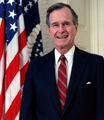

In [270]:
from IPython.display import Image

Image('./wpcd/images/109/10901.jpg', width=300,height=300)

Let's now interest ourselves in the 100 most famous people. To which category do they belong ?

In [271]:
people100= people_centr_sorted.head(100)

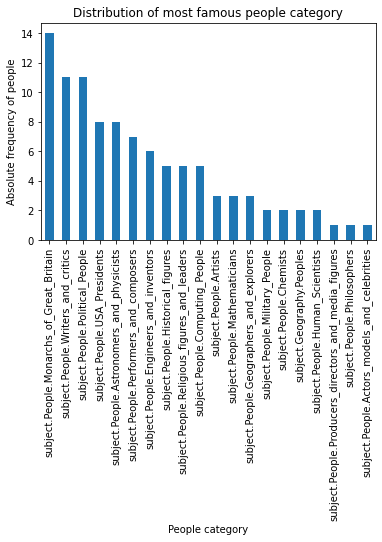

In [272]:
people100['category'].value_counts().plot(kind="bar")
plt.xlabel('People category')
plt.ylabel('Absolute frequency of people')
plt.title('Distribution of most famous people category');

### Let's consider a smaller amount of categories by grouping some of them

In [301]:
people_less_cat = people100
people_less_cat.tail(50)

,article,centrality,category
2673,William_and_Mary,1.954083,Historical Figures
366,Aristotle,1.953504,Philosophers and Human Scientists
2017,George_III_of_the_United_Kingdom,1.942237,Historical Figures
773,Anthropology,1.932948,subject.Geography.Peoples
1559,Richard_I_of_England,1.928511,Historical Figures
1268,Julius_Caesar,1.916347,Historical Figures
2097,Linus_Torvalds,1.915824,Scientists and Engineers
1386,Bob_Dylan,1.915353,Artists
1368,James_Watt,1.910127,Scientists and Engineers
1369,James_Watt,1.910127,Scientists and Engineers


In [306]:
people_less_cat['category'].replace(['subject.People.USA_Presidents'], 'Political People',inplace=True)
people_less_cat['category'].replace(['subject.People.Political_People'], 'Political People',inplace=True)
people_less_cat['category'].replace(['subject.People.Astronomers_and_physicists'], 'Scientists and Engineers',inplace=True)
people_less_cat['category'].replace(['subject.People.Engineers_and_inventors'], 'Scientists and Engineers',inplace=True)
people_less_cat['category'].replace(['subject.People.Chemists'], 'Scientists and Engineers',inplace=True)
people_less_cat['category'].replace(['subject.People.Mathematicians'], 'Scientists and Engineers',inplace=True)
people_less_cat['category'].replace(['subject.People.Performers_and_composers'], 'Artists',inplace=True)
people_less_cat['category'].replace(['subject.People.Artists'], 'Artists',inplace=True)
people_less_cat['category'].replace(['subject.People.Computing_People'], 'Scientists and Engineers',inplace=True)
people_less_cat['category'].replace(['subject.People.Historical_figures'], 'Historical Figures',inplace=True)
people_less_cat['category'].replace(['subject.People.Monarchs_of_Great_Britain'], 'Historical Figures',inplace=True)
people_less_cat['category'].replace(['subject.People.Religious_figures_and_leaders'], 'Religious Figures',inplace=True)
people_less_cat['category'].replace(['subject.People.Human_Scientists'], 'Philosophers and Human Scientists',inplace=True)
people_less_cat['category'].replace(['subject.People.Philosophers'], 'Philosophers and Human Scientists',inplace=True)
people_less_cat['category'].replace(['subject.People.Military_People'], 'Military People',inplace=True)
people_less_cat['category'].replace(['subject.People.Producers_directors_and_media_figures'], 'Filmmaking occupations',inplace=True)
people_less_cat['category'].replace(['subject.People.Actors_models_and_celebrities'], 'Filmmaking occupations',inplace=True)
people_less_cat['category'].replace(['subject.People.Geographers_and_explorers'], 'Geographers',inplace=True)
people_less_cat['category'].replace(['subject.Geography.Peoples'], 'Geographers',inplace=True)
people_less_cat['category'].replace(['subject.People.Writers_and_critics'], 'Writers and Critics',inplace=True)

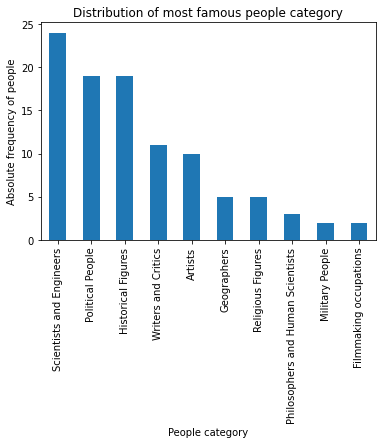

In [307]:
people_less_cat['category'].value_counts().plot(kind="bar")
plt.xlabel('People category')
plt.ylabel('Absolute frequency of people')
plt.title('Distribution of most famous people category');

The histogram shows that amoung the 100 most famous people, the highest number belongs to the `Monarchs_of_Great_Britain` category. This is certainly due to the fact that the Wikispeedia game and Wikipedia pages are writen in english, so mostly used be english speaking users.\
Moreover, the most important category is not robust to the size of the sample we use. Indeed, when selecting the 30 most famous people, the `Writers_and_critics` category is the most important.

In [308]:
#!pip install svgpath2mpl

In [309]:
#!pip install svgpathtools


     -------------------------------------- 67.2/67.2 kB 202.8 kB/s eta 0:00:00
     ---------------------------------------- 67.1/67.1 kB 1.2 MB/s eta 0:00:00


In [310]:
import matplotlib as mpl
from svgpathtools import svg2paths
from svgpath2mpl import parse_path

In [311]:
person_path, attributes = svg2paths('person.svg')

In [312]:
person_marker = parse_path(attributes[0]['d'])

In [314]:
person_marker.vertices -= person_marker.vertices.mean(axis=0)
person_marker = person_marker.transformed(mpl.transforms.Affine2D().rotate_deg(180))
person_marker = person_marker.transformed(mpl.transforms.Affine2D().scale(-1,1))

In [354]:
x = np.linspace(1,5,5)
y = np.linspace(1,20,20)
X, Y = np.meshgrid(x, y)
X = X.reshape((np.prod(X.shape),))
Y = Y.reshape((np.prod(Y.shape),))

In [393]:
people_less_cat = people_less_cat.sort_values(by=['category'])
#people_less_cat['count'] = people_less_cat.groupby('category')['category'].transform('count')
#people_less_cat.sort_values('count', inplace=True, ascending=False)

people_less_cat['X']=Y
people_less_cat['Y']=X
people_less_cat.head()

,article,centrality,category,X,Y,count
2896,Miles_Davis,1.730719,Artists,1.0,1.0,10
1489,Wolfgang_Amadeus_Mozart,2.222177,Artists,1.0,2.0,10
1927,Louis_Armstrong,1.730775,Artists,1.0,3.0,10
42,Leonardo_da_Vinci,2.170778,Artists,1.0,4.0,10
1386,Bob_Dylan,1.915353,Artists,1.0,5.0,10


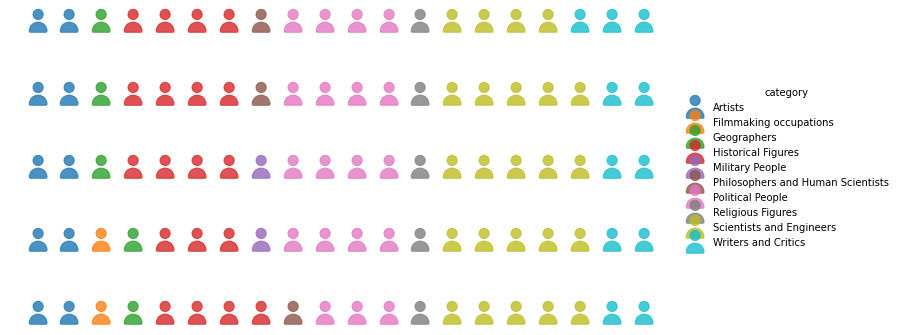

In [396]:
import seaborn as sns
#fig, ax = plt.subplots(figsize=(20, 5))
ax = sns.lmplot(x='X', y='Y', data=people_less_cat, hue='category', fit_reg=False,markers=person_marker , height=5,aspect = 2,scatter_kws={"s": 600})
plt.axis('off')
plt.show()

## 4.D Linking people and countries

One examines how people and countries are related in the wikipedia pages. That means, for example, how many links to countries are there in a people wikipedia page. One first exhibits the usual data information.

In [ ]:
links.head()

,linkSource,linkTarget
0,Áedán_mac_Gabráin,Bede
1,Áedán_mac_Gabráin,Columba
2,Áedán_mac_Gabráin,Dál_Riata
3,Áedán_mac_Gabráin,Great_Britain
4,Áedán_mac_Gabráin,Ireland


In [ ]:
links.describe()

,linkSource,linkTarget
count,119882,119882
unique,4587,4135
top,United_States,United_States
freq,294,1551


The description already shows that the most common link source and target is the United States. This confirms the result one obtained with previous methods.

In [ ]:
links.isna().sum()

linkSource    0
linkTarget    0
dtype: int64

No NaN value appears in the file, so one can directly begin to play with the data.

One can now distinguish four different subsets that relate countries and people: 
1) How a given source country reaches target people.\
2) How a given target people is reached by source countries.\
3) How a given source person reaches target countries.\
4) How a given target country is reached by source people.

Studying these four subsets should provide insights on the asymmetry degree of the relationships and the way people and countries are related.

First, one divides the links in two groups: one according to the source, the other to the target.

In [ ]:
grouped_source_links = links.groupby(by="linkSource")
grouped_source_links.head()

,linkSource,linkTarget
0,Áedán_mac_Gabráin,Bede
1,Áedán_mac_Gabráin,Columba
2,Áedán_mac_Gabráin,Dál_Riata
3,Áedán_mac_Gabráin,Great_Britain
4,Áedán_mac_Gabráin,Ireland
...,...,...
119867,Zulu,AK-47
119868,Zulu,Bantu
119869,Zulu,Cape_Town
119870,Zulu,Christianity


In [ ]:
grouped_source_links.describe()

linkTarget                             
                            count unique              top freq
linkSource                                                    
10th_century                   26     26          Khazars    1
11th_century                   48     48     15th_century    1
12th_century                   45     45     15th_century    1
13th_century                   34     34  Arabic_language    1
14th_century                   31     31     15th_century    1
...                           ...    ...              ...  ...
Åland                          19     19      Nationality    1
Édouard_Manet                  20     20     Claude_Monet    1
Éire                            8      8           Canada    1
Óengus_I_of_the_Picts          10     10    Great_Britain    1
€2_commemorative_coins         47     47        Sanssouci    1

[4587 rows x 4 columns]

In [ ]:
grouped_target_links = links.groupby(by="linkTarget")
grouped_target_links.head()

,linkSource,linkTarget
0,Áedán_mac_Gabráin,Bede
1,Áedán_mac_Gabráin,Columba
2,Áedán_mac_Gabráin,Dál_Riata
3,Áedán_mac_Gabráin,Great_Britain
4,Áedán_mac_Gabráin,Ireland
...,...,...
119862,Zuid-Gelders,Brabantian
119864,Zuid-Gelders,East_Flemish
119872,Zulu,History_of_South_Africa
119873,Zulu,Ladysmith_Black_Mambazo


In [ ]:
grouped_target_links.describe()

linkSource                                
                  count unique                 top freq
linkTarget                                             
10th_century         65     65        15th_century    1
11th_century         57     57        15th_century    1
12th_century         85     85        15th_century    1
13th_century         84     84        15th_century    1
14th_century         71     71        15th_century    1
...                 ...    ...                 ...  ...
Zirconium            15     15              Cerium    1
Zoroaster             9      9  Persian_literature    1
Zuid-Gelders          5      5        East_Flemish    1
Zulu                 14     14        South_Africa    1
Zürich               20     20      Richard_Wagner    1

[4135 rows x 4 columns]

From these groups, only the people and countries interest us. The filtering of these two categories from the two dataset groups is made using the `check_word` function.

In [ ]:
import re

def check_word(word, list_words):
    '''Inputs:
            word: string
            list_words: string
        Return:
            True if the word is in the list_words
            False otherwise
    '''
    if any(article in re.findall(r"[\w']+", word) for article in list_words):
        return True 
    else:
         return False

The previous categories
1) How a given source country reaches target people.\
2) How a given target people is reached by source countries.\
3) How a given source person reaches target countries.\
4) How a given target country is reached by source people.

correspond to the following dataframes : 
1) country_to_people\
2) people_from_country\ 
3) people_to_country\
4) country_from_people.

One only keeps lines that link a people to a country and vice-versa, using the `check_word` function.

In [ ]:
country_to_people = grouped_source_links.filter(lambda x : check_word(str(x['linkSource']), str(all_countries['article'])) & check_word(str(x['linkTarget']), str(people_grouped['article'])))
print('There are {} countries that target people.'.format(len(country_to_people)))
people_from_country = grouped_target_links.filter(lambda x :check_word(str(x['linkSource']), str(all_countries['article'])) & check_word(str(x['linkTarget']), str(people_grouped['article'])))
print('There are {} people that are targeted by countries.'.format(len(people_from_country)))
people_to_country = grouped_source_links.filter(lambda x : check_word(str(x['linkSource']), str(people_grouped['article'])) & check_word(str(x['linkTarget']), str(all_countries['article'])))
print('There are {} people that target countries.'.format(len(people_to_country)))
country_from_people = grouped_target_links.filter(lambda x : check_word(str(x['linkSource']), str(people_grouped['article'])) & check_word(str(x['linkTarget']), str(all_countries['article'])))
print('There are {} countries that are targeted by people.'.format(len(country_from_people)))

There are 214 countries that target people.
There are 349 people that are targeted by countries.
There are 117 people that target countries.
There are 283 countries that are targeted by people.


This four previous results provide insights about the relationships between people and countries. Still, the last line is surprising, since this exceeds by far the number of countries in the world. One will come back on these numbers once the network analysis will be complete, so that one can use this last as a comparison.

# 5. Historical events

With the two previous sections, we started investigating the Wikiworld (i.e the world depicted by Wikipedia’s users through their navigation between articles) on two axes. Indeed, we now know the wikiworld from a geographical point of view, and we have insights into its population (represented by the most important people in the wikispeedia’s graph). But what about its history? 

As before, we will use centrality to determine the most important historical events. The goal is to obtain some kind of chronological timeline with the most important events (according to Wikipedia's users), which will create the history of the Wikiworld.

To begin with, we filter the centrality dataframe by category to extract the articles related to history. Since the category `British_History` has many subcategories, we combine them into one.

In [ ]:
history = centralities[centralities['category'].str.contains('History')]

In [ ]:
history = centralities[centralities['category'].str.contains('History')]
history['category'].mask(history['category'].str.contains('British_History') ,'subject.History.British_History', inplace=True)
history_grouped = history.groupby(by="category")
print("There are {0} historical subjects in the dataset, that are divided in {1} different classes.".format(history.nunique()[0],history.nunique()[2]))

There are 441 historical subjects in the dataset, that are divided in 10 different classes.


C:\Users\manon\anaconda3\lib\site-packages\pandas\core\generic.py:9286: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
history.head()

,article,centrality,category
0,14th_century,1.822051,subject.History.General_history
1,15th_century,1.927752,subject.History.General_history
2,16th_century,2.031601,subject.History.General_history
7,Atlantic_slave_trade,2.310714,subject.History.British_History
13,British_Empire,2.522856,subject.History.British_History


We sort the articles based on their importance on the graph, i.e. their centrality:

In [ ]:
history_sorted = history.sort_values(by=['centrality'],ascending=False)
history_sorted.head(10)

,article,centrality,category
62,World_War_II,2.546083,subject.History.British_History
13,British_Empire,2.522856,subject.History.British_History
239,Great_Britain,2.491359,subject.History.British_History
63,Nuclear_weapon,2.487048,subject.History.Military_History_and_War
130,American_Civil_War,2.486808,subject.History.Pre_1900_Military
923,Nazi_Germany,2.480684,subject.History.World_War_II
884,United_States_Declaration_of_Independence,2.474992,subject.History.North_American_History
944,Elizabeth_II_of_the_United_Kingdom,2.470971,subject.History.British_History
809,Cold_War,2.468385,subject.History.Recent_History
385,Soviet_Union,2.447202,subject.History.Recent_History


Let’s consider only the 30 most popular / more important events/subjects related to History. What can we say about them ?

In [ ]:
history30 = history_sorted.head(30)

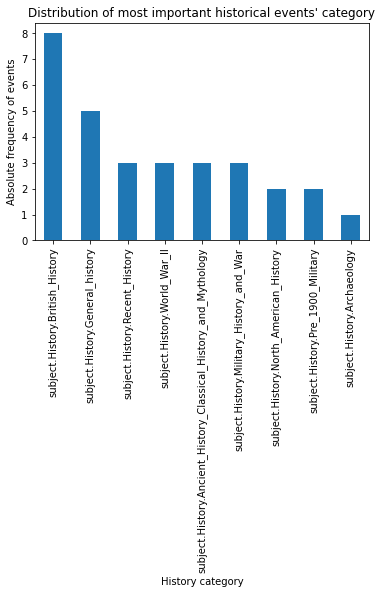

In [ ]:
history30['category'].value_counts().plot(kind="bar")
plt.xlabel('History category')
plt.ylabel('Absolute frequency of events')
plt.title('Distribution of most important historical events\' category');

We face an issue here. Indeed, our first idea was to consider only the historical events to make some kind of chronological timeline. However, looking into the articles that we have, many of the ones related to history, especially the most central ones, are not historical events (for example British_Empire, Nuclear_Weapon…). The question is now, what can we do with those to characterize the history that is told by Wikispeedia’s graph? If we consider the category, then British History is predominant. Should we focus on Recent History ? Find a way to filter the events ? Make clusters ?

All these questions are open and will be discussed or addressed later in this project.

# 6. Appendix

The article names are URL-encoded. Thus, the following code allows to decode the article names. We did not use it here, because the URL names reveal useful to access the files (as in 'wpcd' folder), but might use it in the future for better readability. This code will be applied at the very end of the data analysis steps.

In [ ]:
from urllib.parse import unquote

articles['article'] = articles['article'].apply(lambda x: unquote(x))
categories['article'] = categories['article'].apply(lambda x: unquote(x))
links['linkSource'] = links['linkSource'].apply(lambda x: unquote(x))
links['linkTarget'] = links['linkTarget'].apply(lambda x: unquote(x))
path_finished['path'] = path_finished['path'].apply(lambda x: unquote(x))
path_unfinished['path'] = path_unfinished['path'].apply(lambda x: unquote(x))
path_unfinished['target'] = path_unfinished['target'].apply(lambda x: unquote(x))

AttributeError: 'list' object has no attribute 'split'